In [10]:
import numpy as np
import tensorflow.contrib.slim as slim
import scipy.signal
import gym
import os
import threading
import multiprocessing
import tensorflow as tf
import ac_network
import worker
import matplotlib.pyplot as plt

import importlib
importlib.reload(ac_network)
importlib.reload(worker)

from ac_network import AC_Network
from worker import Worker

** Setup of hyperparameters **

In [4]:
# Tensorboard dir
LOG_DIR = '/home/adrian/Schreibtisch/Uni/Data-Innovation-Lab/DILAB/tensorflowlogs'

# Gym environment
ENV_NAME = 'CartPole-v0'  # Discrete (4, 2)
RANDOM_SEED = 1234
STATE_DIM = 4
ACTION_DIM = 2

# Neural network spec
CELL_UNITS = 16
# Learning rate
LEARNING_RATE = 0.0005

# Exploration spec
ENTROPY_REGULARIZATION = True
ENTROPY_REGULARIZATION_LAMBDA = 0.1
# Noisy net settings 
# 1.Option --> None (normal fully connected layers)
# 2.Option --> "factorized"
# 3.Option --> "independent"
NOISE_DIST = 'factorized'

# Size of mini batches to run training on
MINI_BATCH = 40
REWARD_FACTOR = 0.001
# Discount rate for advantage estimation and reward discounting
GAMMA = 0.99
EPISODE_RUNS = 1000

In [243]:
network_config = dict(shared = True,
                      shared_config = dict(kind = 'RNN',
                                           Cell_Units = 16),
                      policy_config = dict(layers = [2],
                                           noise_dist = "factorized"),
                      value_config = dict(layers = [1],
                                          noise_dist = "factorized"))

In [61]:
#MAIN
#def main(_):
global master_network
global global_episodes

tf.reset_default_graph()

with tf.device('/job:local/task:0/device:CPU:0'): #Parameter server adress
    RANDOM_SEED = 1234
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

    global_episodes = tf.Variable(0, dtype=tf.int32, name='global_episodes', trainable=False)
    trainer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    master_network = AC_Network(STATE_DIM, ACTION_DIM, 'global', None, network_config)  # Generate global network
    num_workers = 2  # Number of workers

    workers = []
    # Create worker classes
    with tf.device('/job:local/task:1/device:CPU:0'): #Worker server adresses
        workers.append(Worker(0, STATE_DIM, ACTION_DIM, trainer, network_config, global_episodes,
                              ENV_NAME, RANDOM_SEED))
    with tf.device('/job:local/task:1/device:CPU:0'):
        workers.append(Worker(1, STATE_DIM, ACTION_DIM, network_config, trainer, global_episodes,
                              ENV_NAME, RANDOM_SEED))

with tf.Session("grpc://localhost:2222") as sess:
    coord = tf.train.Coordinator()
    merged = tf.summary.merge_all()    
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    sess.run(tf.global_variables_initializer())

    # This is where the asynchronous magic happens.
    # Start the "work" process for each worker in a separate thread.
    worker_threads = []
    worker=workers[0]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    worker=workers[1]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    print("Start")
    coord.join(worker_threads)

#tf.app.run()


factorized
Tensor("global/Reshape:0", shape=(?, 16), dtype=float32, device=/job:local/task:0/device:CPU:0)
Hier 
Tensor("global/noise_action_trainable/add:0", shape=(16, 2), dtype=float32, device=/job:local/task:0/device:CPU:0)
Hier 
Tensor("global/noise_value_trainable/add:0", shape=(16, 1), dtype=float32, device=/job:local/task:0/device:CPU:0)
factorized
Tensor("worker_0/Reshape:0", shape=(?, 16), dtype=float32, device=/job:local/task:1/device:CPU:0)
Hier 
Tensor("worker_0/noise_action_trainable/add:0", shape=(16, 2), dtype=float32, device=/job:local/task:1/device:CPU:0)
Hier 
Tensor("worker_0/noise_value_trainable/add:0", shape=(16, 1), dtype=float32, device=/job:local/task:1/device:CPU:0)
factorized
Tensor("worker_1/Reshape:0", shape=(?, 16), dtype=float32, device=/job:local/task:1/device:CPU:0)
Hier 
Tensor("worker_1/noise_action_trainable/add:0", shape=(16, 2), dtype=float32, device=/job:local/task:1/device:CPU:0)
Hier 
Tensor("worker_1/noise_value_trainable/add:0", shape=(16, 1)

Get rewards collected by the different agents

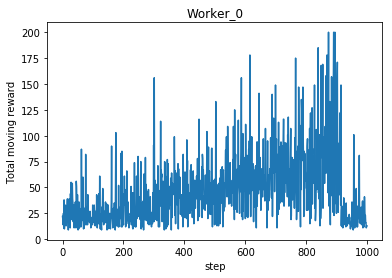

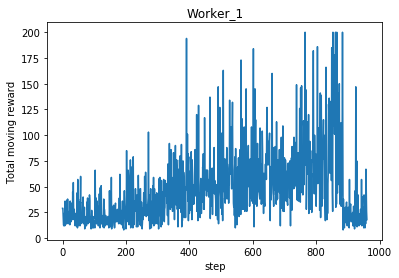

In [62]:
plotListNoNoisyNet = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotListNoNoisyNet.append(plt)
    plt.show()

200.0


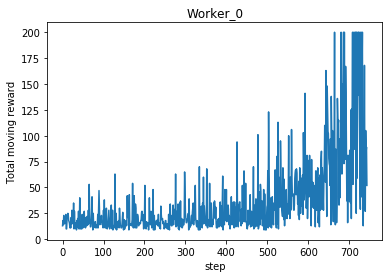

200.0


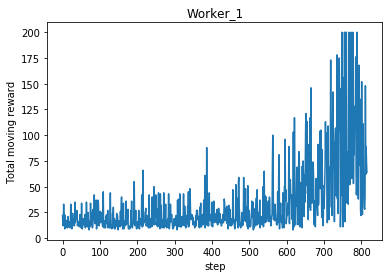

In [36]:
plotList = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    print(np.max(rewards))
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotList.append(plt)
    plt.show()